In [911]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import f1_score
import torch.nn.functional as F


In [912]:
train = pd.read_csv("../Data/TaskA_train_neural_kg.csv", index_col=0)
test = pd.read_pickle("../Data/TaskA_test_neural_kg.pkl")

In [913]:
# Get 50-50 split
n_half = int((len(train) + len(test))*0.5)

test_set_new = train.sample(n=len(train)-n_half, random_state=42)

# Drop the selected rows from the original dataframe to update the training set
train = train.drop(test_set_new.index)
test = pd.concat([test, test_set_new])

In [914]:
# Only predicting validity
X_train = train.loc[:, ["topic", "Premise", "Conclusion", "SBERT_premise", "SBERT_conclusion", "SBERT_cosine_sim", "Irrelevancy", "Validity-Confidence"]]
                        #, "Novelty-Confidence"]]
y_train = train.loc[:, "Validity"]
X_test = test.loc[:, ["topic", "Premise", "Conclusion", "SBERT_premise", "SBERT_conclusion", "SBERT_cosine_sim", "Irrelevancy", "Validity-Confidence", ]]
                      #"Novelty-Confidence"]]
y_test = test.loc[:, "Validity"]

In [929]:
def str_to_list(text):
    '''
    Return tensor string into list
    '''
    # clean string
    clean_str = text.replace('tensor(', '').replace(')', '').strip()
    # convert to list
    tensor = eval(clean_str, {"torch": torch, "__builtins__": {}})
    return tensor

def process_covariate_data(df):
    '''
    Expanding all tensors in a single cell
    Make confidence into ordinal variables
    '''
    # convert str to tensor (list)
    SBERT_premise = df.SBERT_premise.apply(lambda x: str_to_list(x))
    SBERT_conclusion = df.SBERT_conclusion.apply(lambda x: str_to_list(x))

    # expand the list into individual entries
    df_expand1 = SBERT_premise.apply(pd.Series)
    df_expand2 = SBERT_conclusion.apply(pd.Series)

    # assign a meaningful name
    df_expand1.columns = ['pre_emb{}'.format(i+1) for i in range(df_expand1.shape[1])]
    df_expand2.columns = ['con_emb{}'.format(i+1) for i in range(df_expand2.shape[1])]

    # convert confidence into ordinal variable
    confidence_mapping = {
        'very confident': 3,
        'confident': 2,
        'majority': 1,
        'defeasible': 0
    }
    df['Validity-Confidence'] = df['Validity-Confidence'].replace(confidence_mapping)
    #df["Novelty-Confidence"] = df['Novelty-Confidence'].replace(confidence_mapping)

    # put everything together
    df_final = pd.concat([df.drop(['SBERT_premise', "SBERT_conclusion"], axis=1), df_expand1, df_expand2], axis=1)
    return df_final

def preprocess_input(x, y):
    '''
    return DataLoader for later input into the model
    '''
    # pd.dataframe to array
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    # transform y for nn model
    # assume a value of 0 is not valid/novel
    y[y == -1] = 0

    # array to tensor
    x_torch = torch.tensor(x)
    y_torch = torch.tensor(y)
    data = TensorDataset(x_torch, y_torch)

    batch_size = 32
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return loader

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.input_dim = 1542
        self.hidden_dim = 30
        self.output_dim = 4
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)  # Assuming n input features
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)  # Batch normalization layer
        #self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)  # Outputs 4 values, one for each output column
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.float()
        x = torch.relu(self.bn1(self.fc1(x)))
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(1539, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        #self.layer2 = nn.Linear(512, 256)
        #self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.5)
        #self.layer3 = nn.Linear(256, 128)
        #self.relu3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.5)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        #x = self.layer2(x)
        #x = self.relu2(x)
        #x = self.dropout2(x)
        #x = self.layer3(x)
        #x = self.relu3(x)
        #x = self.dropout3(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

model = BinaryClassifier()


In [930]:
X_train1 = process_covariate_data(X_train)
X_test1 = process_covariate_data(X_test)

In [931]:
train_loader = preprocess_input(X_train1.iloc[:, 3:], y_train)
test_loader = preprocess_input(X_test1.iloc[:, 3:], y_test)

In [932]:
model = BinaryClassifier()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [933]:
epochs = 60
for epoch in range(epochs):
    # for each batch
    model.train()  # Set model to training mode
    total = 0
    correct = 0
    total_loss = 0
    
    all_preds = []
    all_labels = []

    for inputs, targets in train_loader:
        inputs = inputs.float()
        targets = targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to remove the extra dimension
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Get accuracy
        total_loss += loss.item()
        predicted = (outputs >= 0.5).float()  # Convert probabilities to 0 or 1
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.tolist())
        all_labels.extend(targets.tolist())
        
    accuracy = 100 * correct / total

    # Optionally print the loss every few epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        print(f"Accuracy: {accuracy}%")

conf_matrix = confusion_matrix(all_labels, all_preds)

Epoch 1, Loss: 0.56232750415802
Accuracy: 55.16074450084602%
Epoch 6, Loss: 0.45437857508659363
Accuracy: 75.80372250423012%
Epoch 11, Loss: 0.25783854722976685
Accuracy: 84.0947546531303%
Epoch 16, Loss: 0.4340305030345917
Accuracy: 84.4331641285956%
Epoch 21, Loss: 0.23443622887134552
Accuracy: 87.30964467005076%
Epoch 26, Loss: 0.22087310254573822
Accuracy: 85.78680203045685%
Epoch 31, Loss: 0.21122080087661743
Accuracy: 88.3248730964467%
Epoch 36, Loss: 0.352852463722229
Accuracy: 89.5093062605753%
Epoch 41, Loss: 0.24773910641670227
Accuracy: 90.52453468697124%
Epoch 46, Loss: 0.009789255447685719
Accuracy: 91.37055837563452%
Epoch 51, Loss: 0.10190202295780182
Accuracy: 89.5093062605753%
Epoch 56, Loss: 0.04863359034061432
Accuracy: 90.52453468697124%


In [934]:
# Training confusion matrix
conf_matrix

array([[258,  12],
       [ 54, 267]])

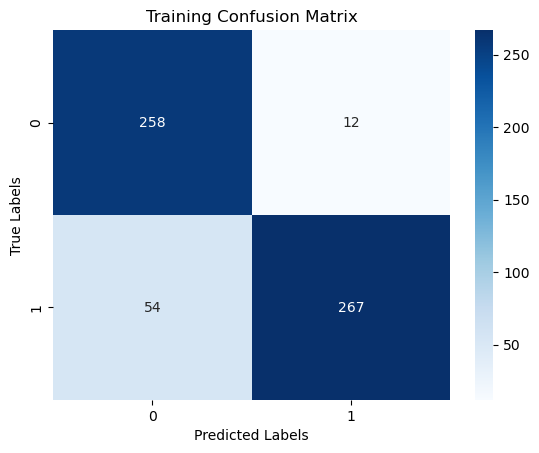

In [935]:
# Optional: Visualizing the Training confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()


In [936]:
# Remove zeros from y_tests
y_test = y_test.replace(-1, 0).astype(float)

In [937]:
def predict(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actual_labels = []
    
    with torch.no_grad():  
        for inputs, labels in data_loader:
            inputs = inputs.float()
            #labels = labels.float()
            
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            predicted_labels = (outputs.squeeze() >= 0.5).long()  # Apply threshold and convert to long dtype

            #outputs = outputs.squeeze()  # Adjusting dimensions if necessary
            #print(predicted_labels)
            #predicted_labels = (outputs >= 0.1).long()  # Applying threshold to convert to class labels
            predictions.extend(predicted_labels.tolist())
            actual_labels.extend(labels.tolist())
    
    return actual_labels, predictions


In [938]:
from sklearn.metrics import confusion_matrix

# Assuming test_loader is your DataLoader for the test set
actual_labels, predictions = predict(model, test_loader)


In [939]:
conf_matrix = confusion_matrix(actual_labels, predictions)


In [940]:
conf_matrix

array([[179,  75],
       [210, 127]])

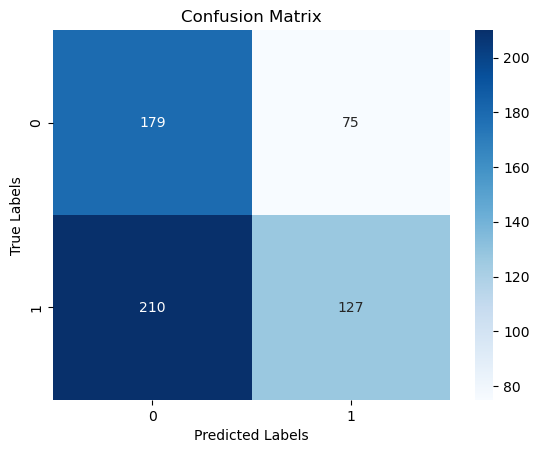

In [941]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [942]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(actual_labels, predictions)
recall = recall_score(actual_labels, predictions)
f1 = f1_score(actual_labels, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.6287128712871287
Recall: 0.3768545994065282
F1 Score: 0.4712430426716141
